In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
from analysis_utilities import aggregate_by_time_and_plot, aggregate_by_event_time_and_plot, \
    select_controls, test_balance, add_missing_indicators, prepare_df, generate_variable_names

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_200m/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_200m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

analysis='group_3_crimes_50m'

In [2]:
import numpy as np

value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = generate_variable_names(analysis=analysis)

# Uncomment below line for "any crime" analysis
# df[value_vars_crime] = np.where(df[value_vars_crime] > 0, 1, 0)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis, output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                            Investigations Within 50m, Oct. 2022   
                                                 \emph{Independent Variable}                                                       
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_3_crimes_50m                                8.454742e-30   
                                                 pre_treatment_change_in_group_3_crimes_50m                         5.646905e-02   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                 3.815567e-01   
                                                 job_density_2013                                                   2.725662e-01   
                                                 med_hhinc2016                                                      1.275931e-02   
                                                 poor_share2010                                                     1.010264e-03   
                                                 popdensity2010                                                     7.156731e-01   
                                                 rent_twobed2015                                                    6.544634e-01   
                                                 share_white2010                                                    1.317939e-01   
                                                 traveltime15_2010                                                  2.511899e-01   
Panel C: Case Initiation                         for_cause                                                          5.623425e-01   
                                                 no_cause                                                           1.378069e-01   
                                                 non_payment                                                        1.457003e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                           3.328854e-01   
                                                 hasAttyP                                                           4.842109e-03   
                                                 isEntityD                                                          3.529460e-02   
                                                 isEntityP                                                          1.810437e-03   

                                                                                                               
                                                                                            Plaintiff Victory  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_3_crimes_50m             9.478034e-01  
                                                 pre_treatment_change_in_group_3_crimes_50m      8.834551e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              2.403331e-01  
                                                 job_density_2013                                1.626836e-01  
                                                 med_hhinc2016                                   1.910501e-01  
                                                 poor_share2010                                  1.428679e-01  
                                                 popdensity2010                                  5.946111e-02  
                                                 rent_twobed2015                                 5.003043e-01  
                                                 share_white2010                                 9.829904e-02  
                                                 traveltime15_2010                               2.271578e-01  
Panel C: Case

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                            Cases Won by Plaintiff   
Panel A twenty_seventeen_group_3_crimes_50m               0.115425   
Panel B med_hhinc2016                                 48035.651626   
        poor_share2010                                    0.273292   
Panel D hasAttyP                                          0.879853   
        isEntityD                                         0.014166   
        isEntityP                                         0.808499   

                                            Difference in Cases Won by Defendant  \
                                                                      Unweighted   
Panel A twenty_seventeen_group_3_crimes_50m                             0.001347   
Panel B med_hhinc2016                                                1777.651626   
        poor_share2010                                                  0.011240   
Panel D hasAttyP                                                        0.071601   
        isEntityD                                                      -0.039232   
        isEntityP                                                       0.099762   

                                                                       \
                                                 \emph{p}    Weighted   
Panel A twenty_seventeen_group_3_crimes_50m  9.478034e-01   -0.001098   
Panel B med_hhinc2016                        1.910501e-01 -385.454430   
        poor_share2010                       1.428679e-01   -0.002127   
Panel D hasAttyP                             1.016046e-04   -0.004767   
        isEntityD                            4.881644e-07   -0.002449   
        isEntityP                            6.134468e-06   -0.002386   

                                                       
                                             \emph{p}  
Panel A twenty_seventeen_group_3_crimes_50m  0.958019  
Panel B med_hhinc2016                        0.775181  
        poor_share2010                       0.779091  
Panel D hasAttyP                             0.763702  
        isEntityD                            0.698147  
        isEntityP                            0.894882

In [5]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

# Generate indicators for missing data.
add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = prepare_df(df, analysis, treatment_date_variable, pre_treatment_covariates, value_vars_crime, month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:16<00:00, 134.61it/s]


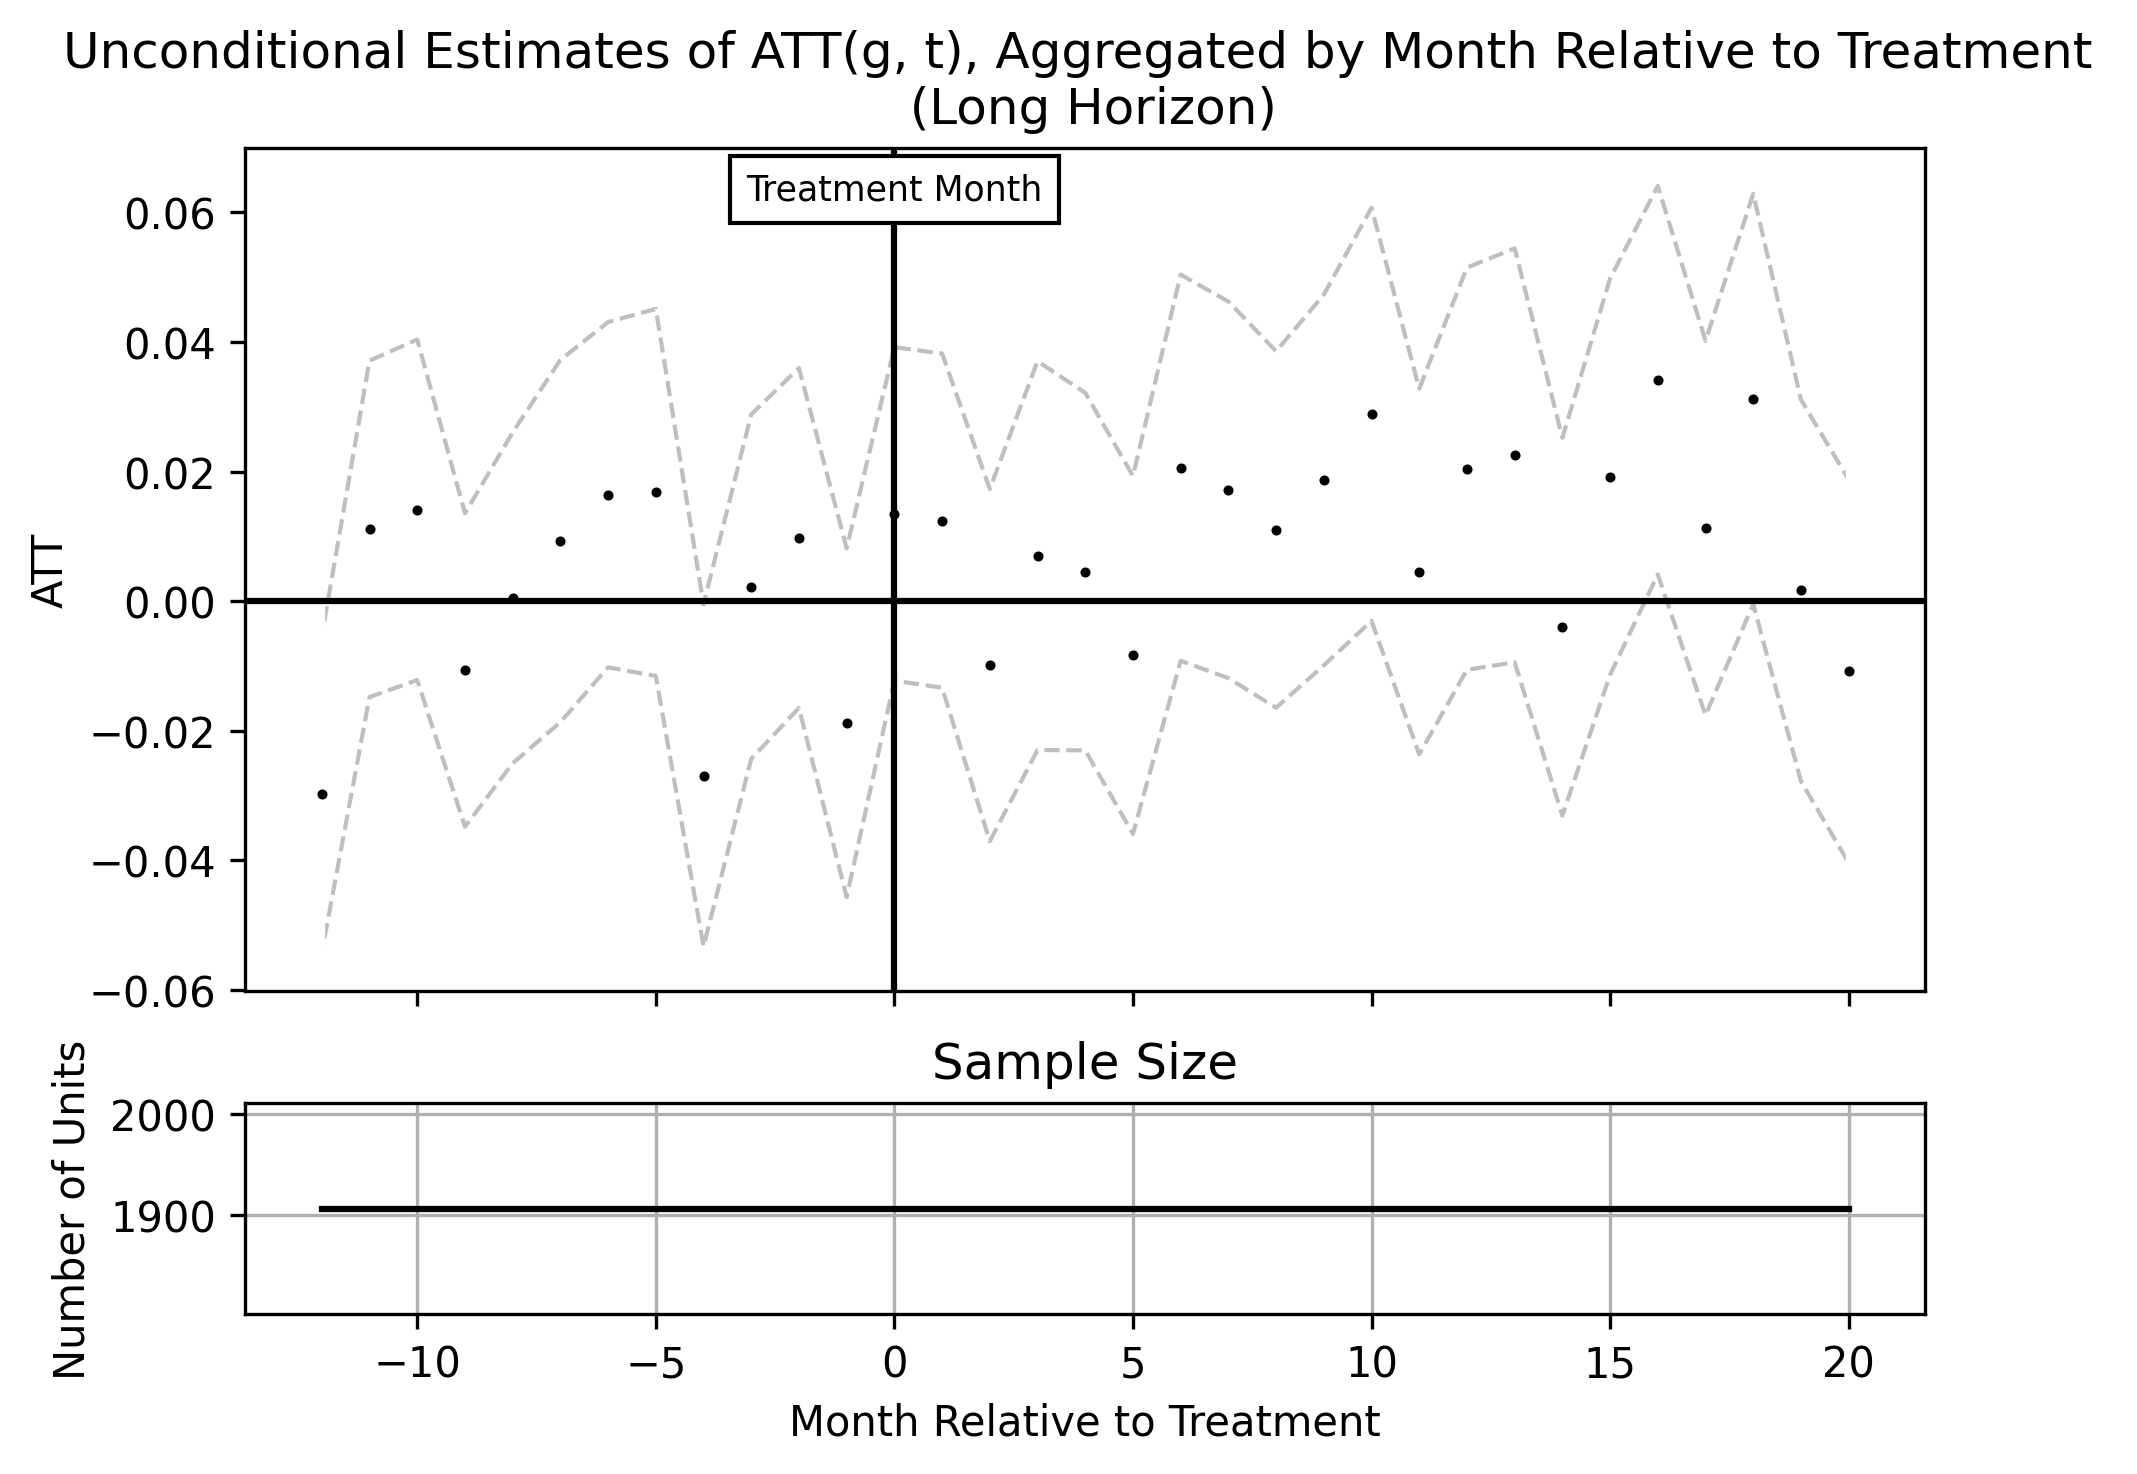

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=20,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

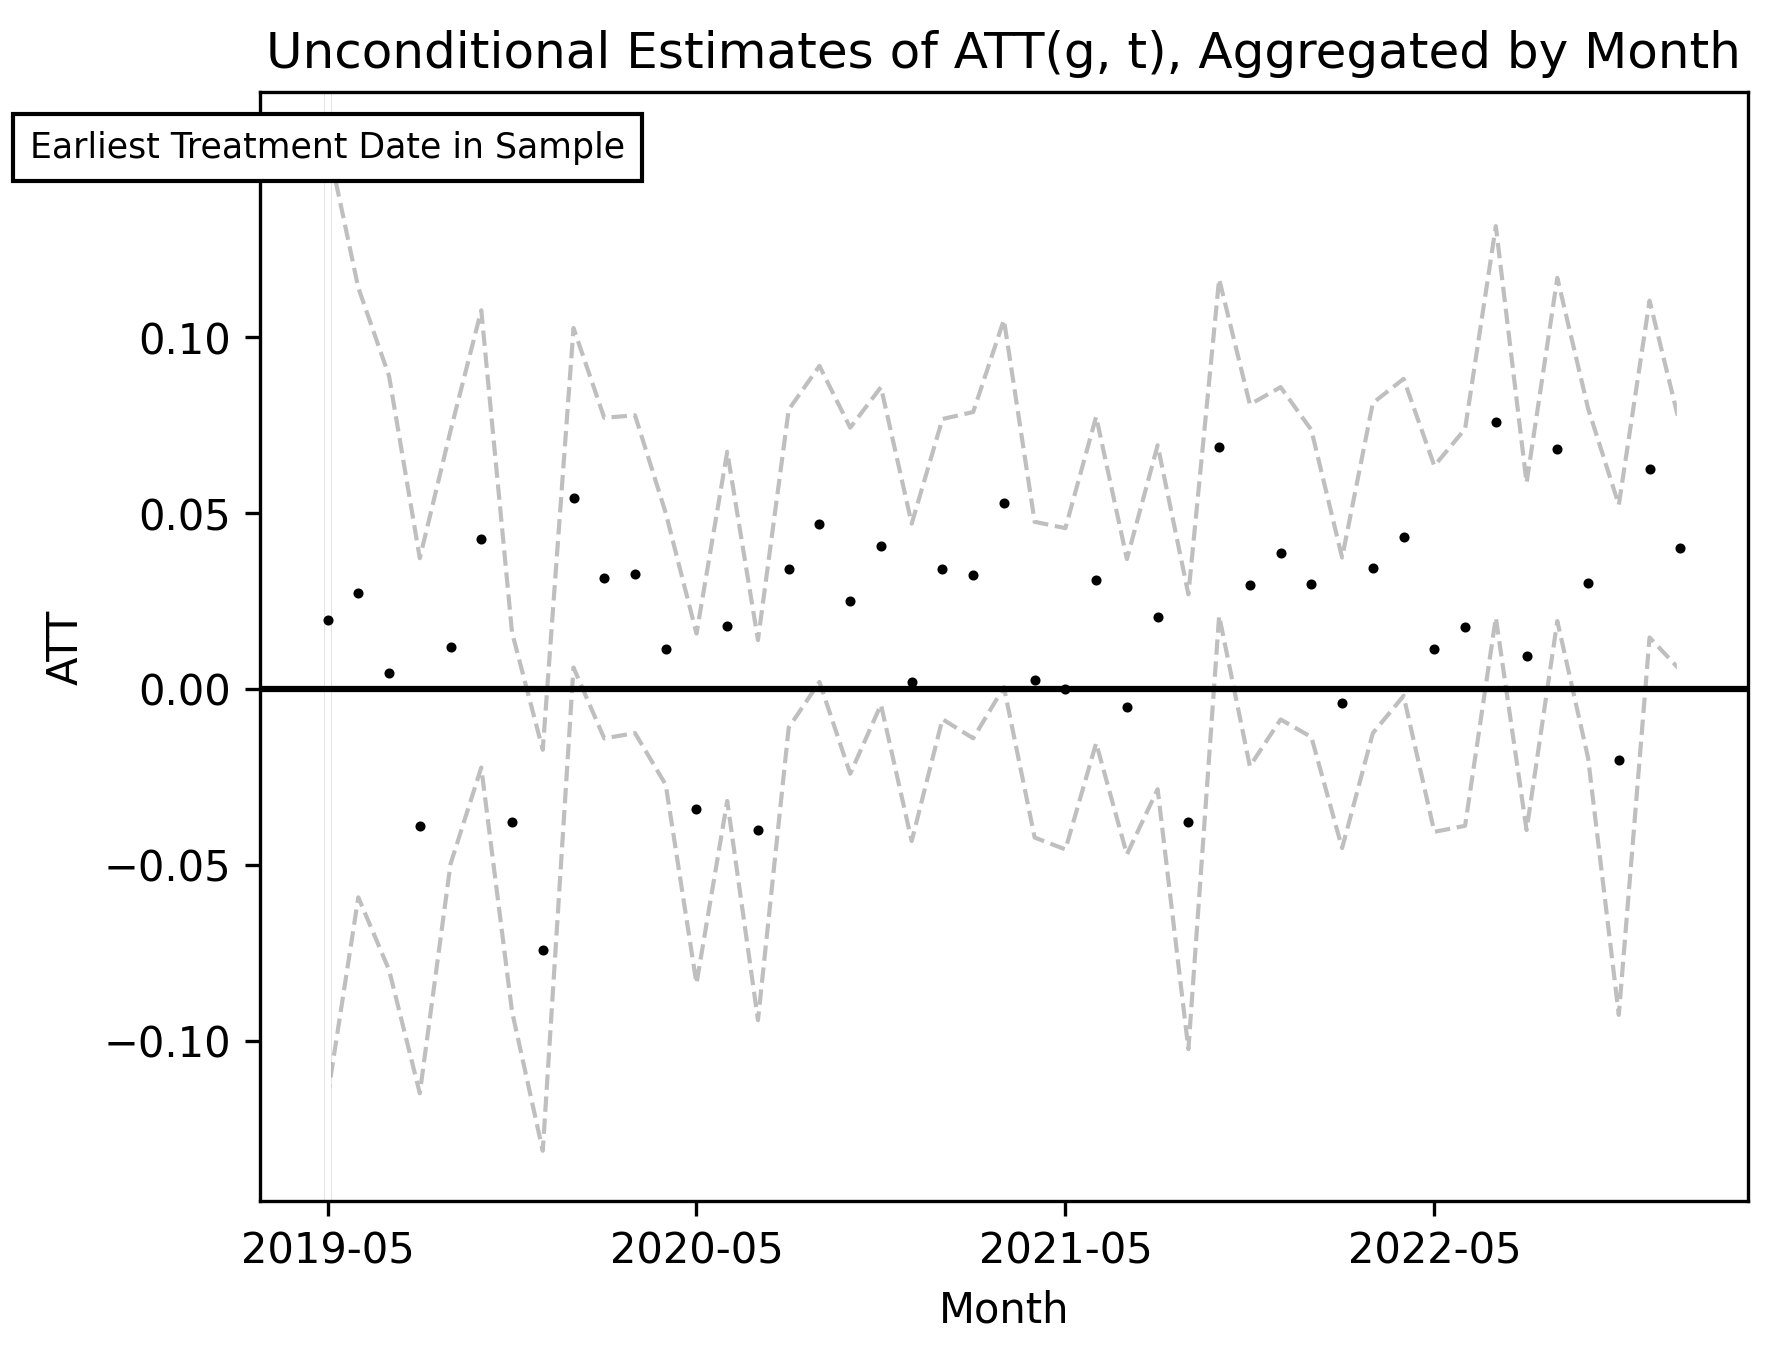

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:34<00:00, 63.57it/s] 


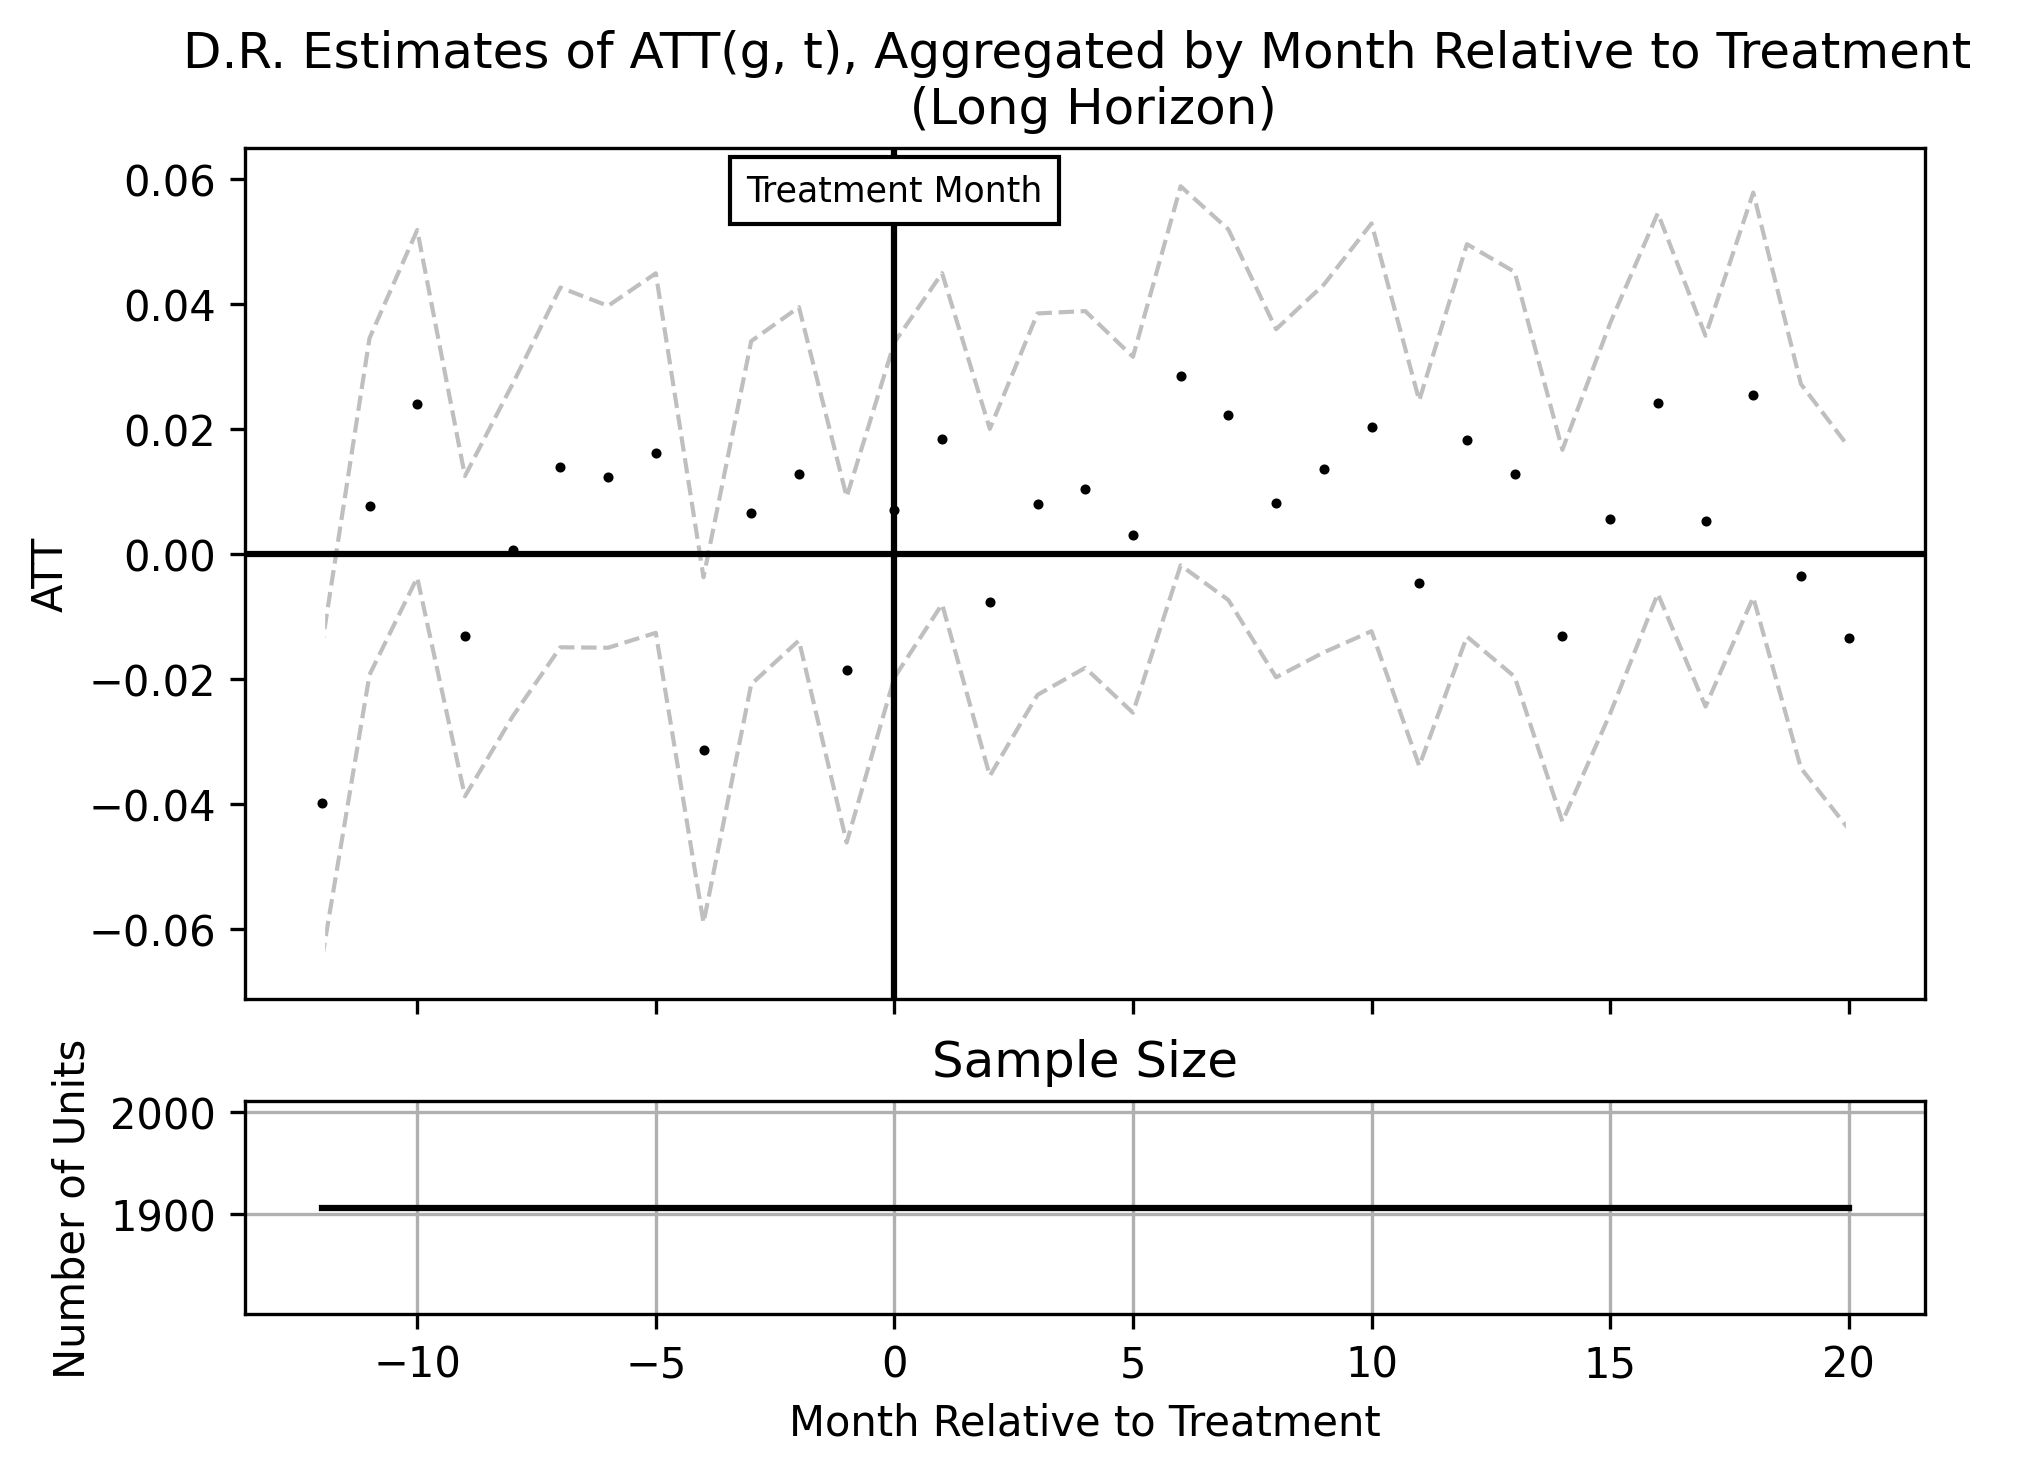

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

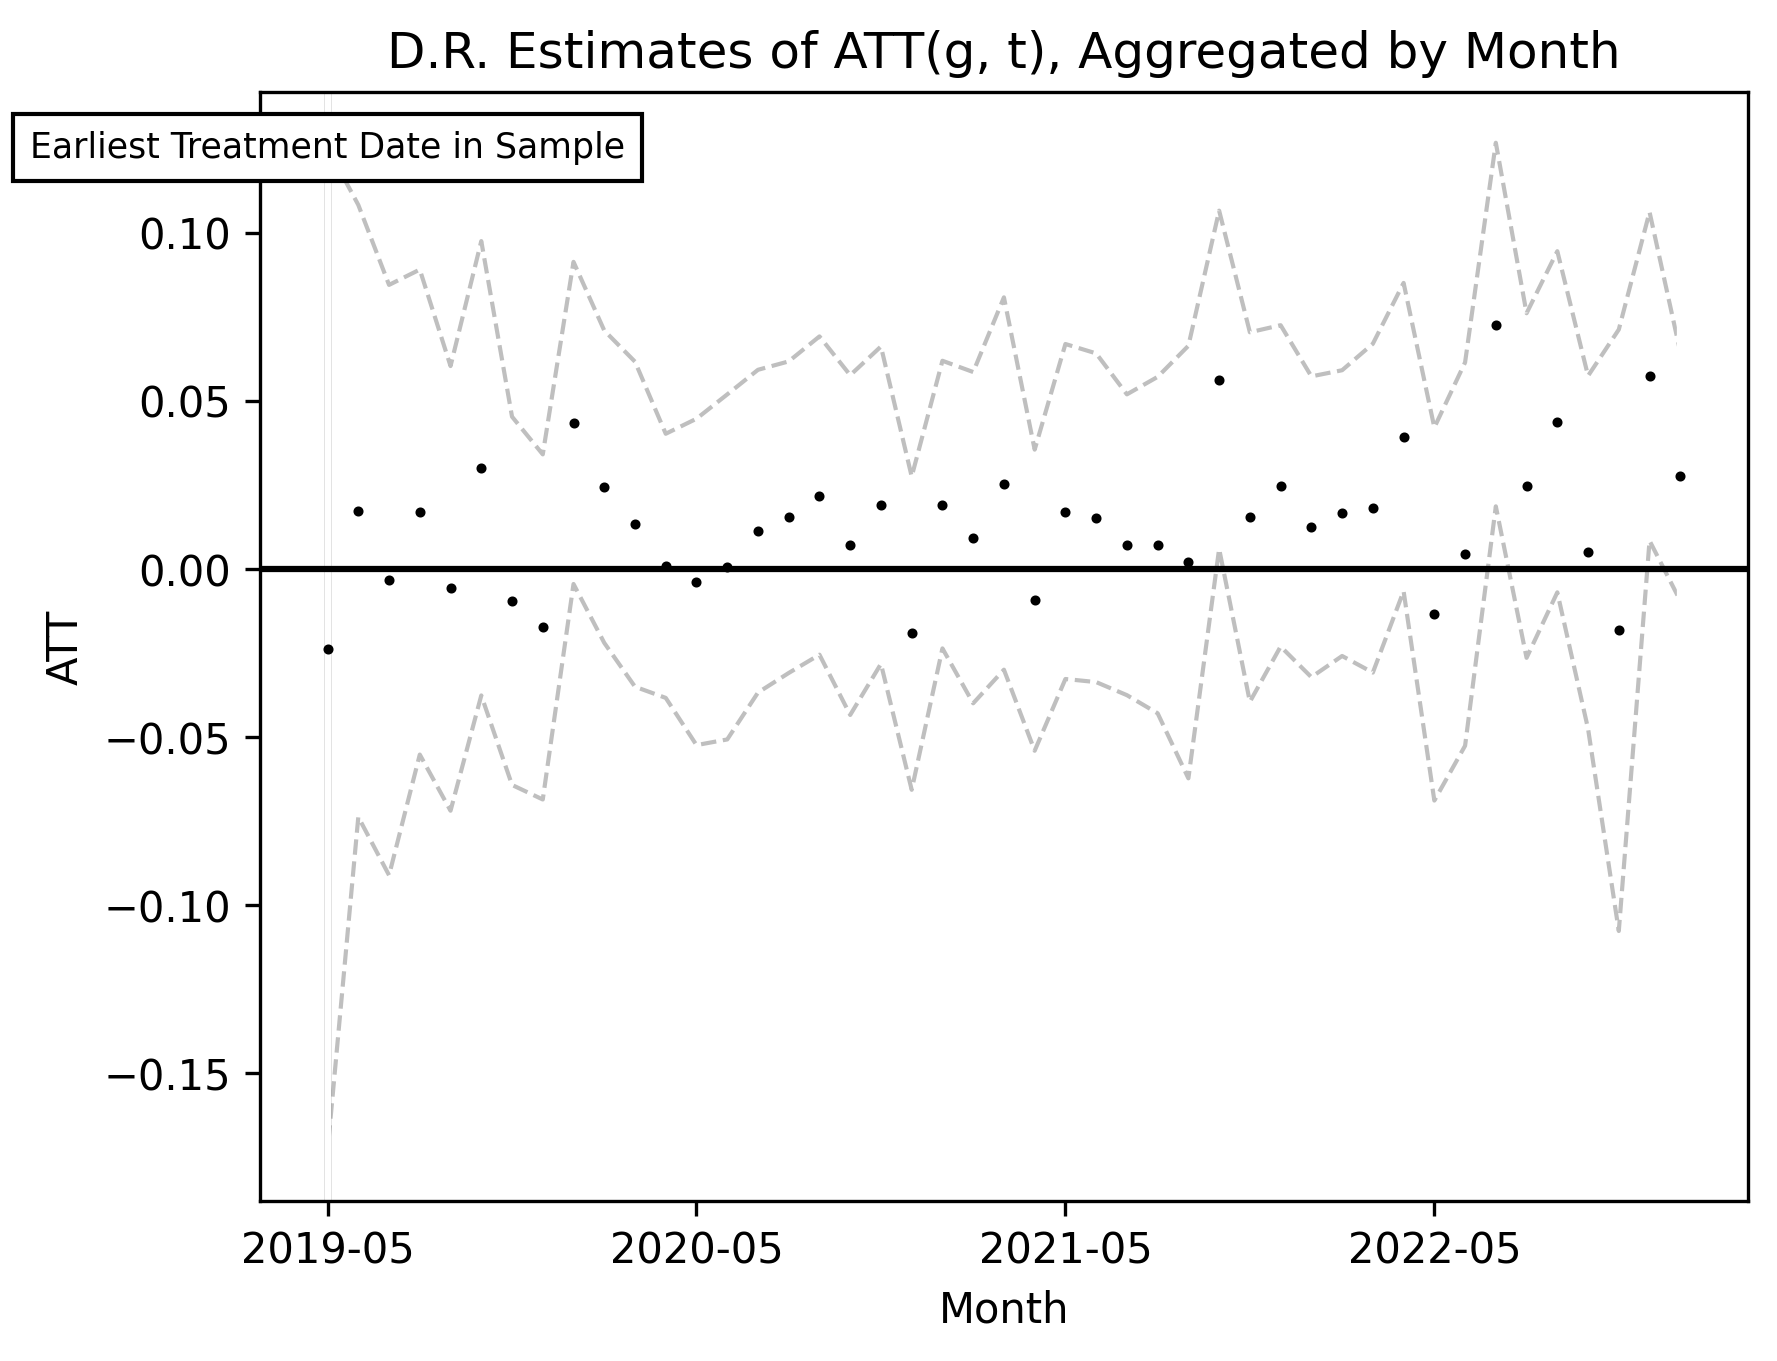

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")